In [4]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats

Establish connection.

In [5]:
host = 'localhost'
database = 'Car'
user = 'postgres'
password = 'HarryHogwarts'

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}')

Get tables. EDA mainly focuses on cars, so this is queried seperately.

In [6]:
query = "SELECT * FROM cars"
cars = pd.read_sql(query, engine)
cars

,car_id,car_name,car_company,max_speed,acceleration,hp,market_price
0,1,A5 Coupé,Audi,228.0,8.2,NaN,45827.00
1,2,A1 Sportback,Audi,193.0,NaN,95.0,23353.00
2,3,A3 Sportback,Audi,204.0,NaN,110.0,30545.00
3,4,A4 Avant,Audi,220.0,NaN,150.0,43055.00
4,5,316d Limousine,BMW,204.0,9.8,122.0,48350.00
5,6,330e xDrive Limousine,BMW,230.0,5.8,292.0,55400.00
6,7,420i Coupé,BMW,240.0,7.5,184.0,59450.00
7,8,520i Limousine,BMW,230.0,7.5,208.0,64575.90
8,9,XM,BMW,250.0,4.3,748.0,174100.00
9,10,Roma,Ferrari,320.0,3.4,620.0,NaN


In [7]:
query = "SELECT * \
         FROM cars \
         FULL OUTER JOIN orders \
             ON cars.car_id = orders.car_id \
         FULL OUTER JOIN customers \
             ON orders.customer_id = customers.customer_id"
df = pd.read_sql(query, engine)
# df

Next the column names are changed. Also the id column is dropped.

In [8]:
cars = cars.drop("car_id", axis = 1)
new_col_names = ["Name", "Company", "Maximum_Speed", "Acceleration", "Horsepower", "Market_Price"]
cars.columns = new_col_names

# Exploratory Data Analysis

Frequency of models by car company

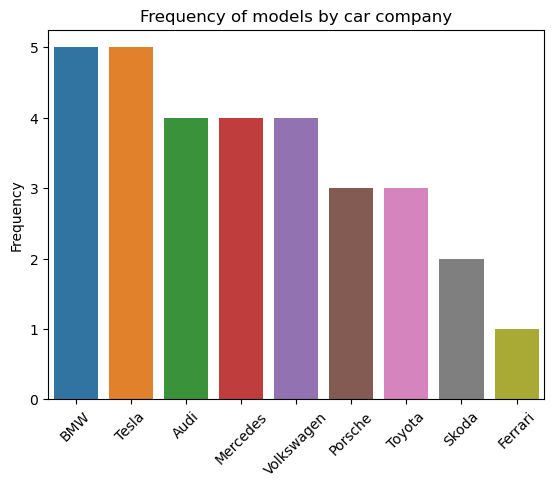

In [9]:
ordered_companies = cars.Company.value_counts().index
sns.countplot(x = cars.Company, order = ordered_companies)
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Frequency of models by car company")
plt.xticks(rotation=45)
plt.yticks(range(0, 6))
plt.show()

In [10]:
cars.Company.value_counts()

BMW           5
Tesla         5
Audi          4
Mercedes      4
Volkswagen    4
Porsche       3
Toyota        3
Skoda         2
Ferrari       1
Name: Company, dtype: int64

How many NULL values are in the columns?

In [11]:
cars.isnull().sum()

Name             0
Company          0
Maximum_Speed    1
Acceleration     9
Horsepower       3
Market_Price     1
dtype: int64

The following plots from the missingno package visualize the NULL values very well.

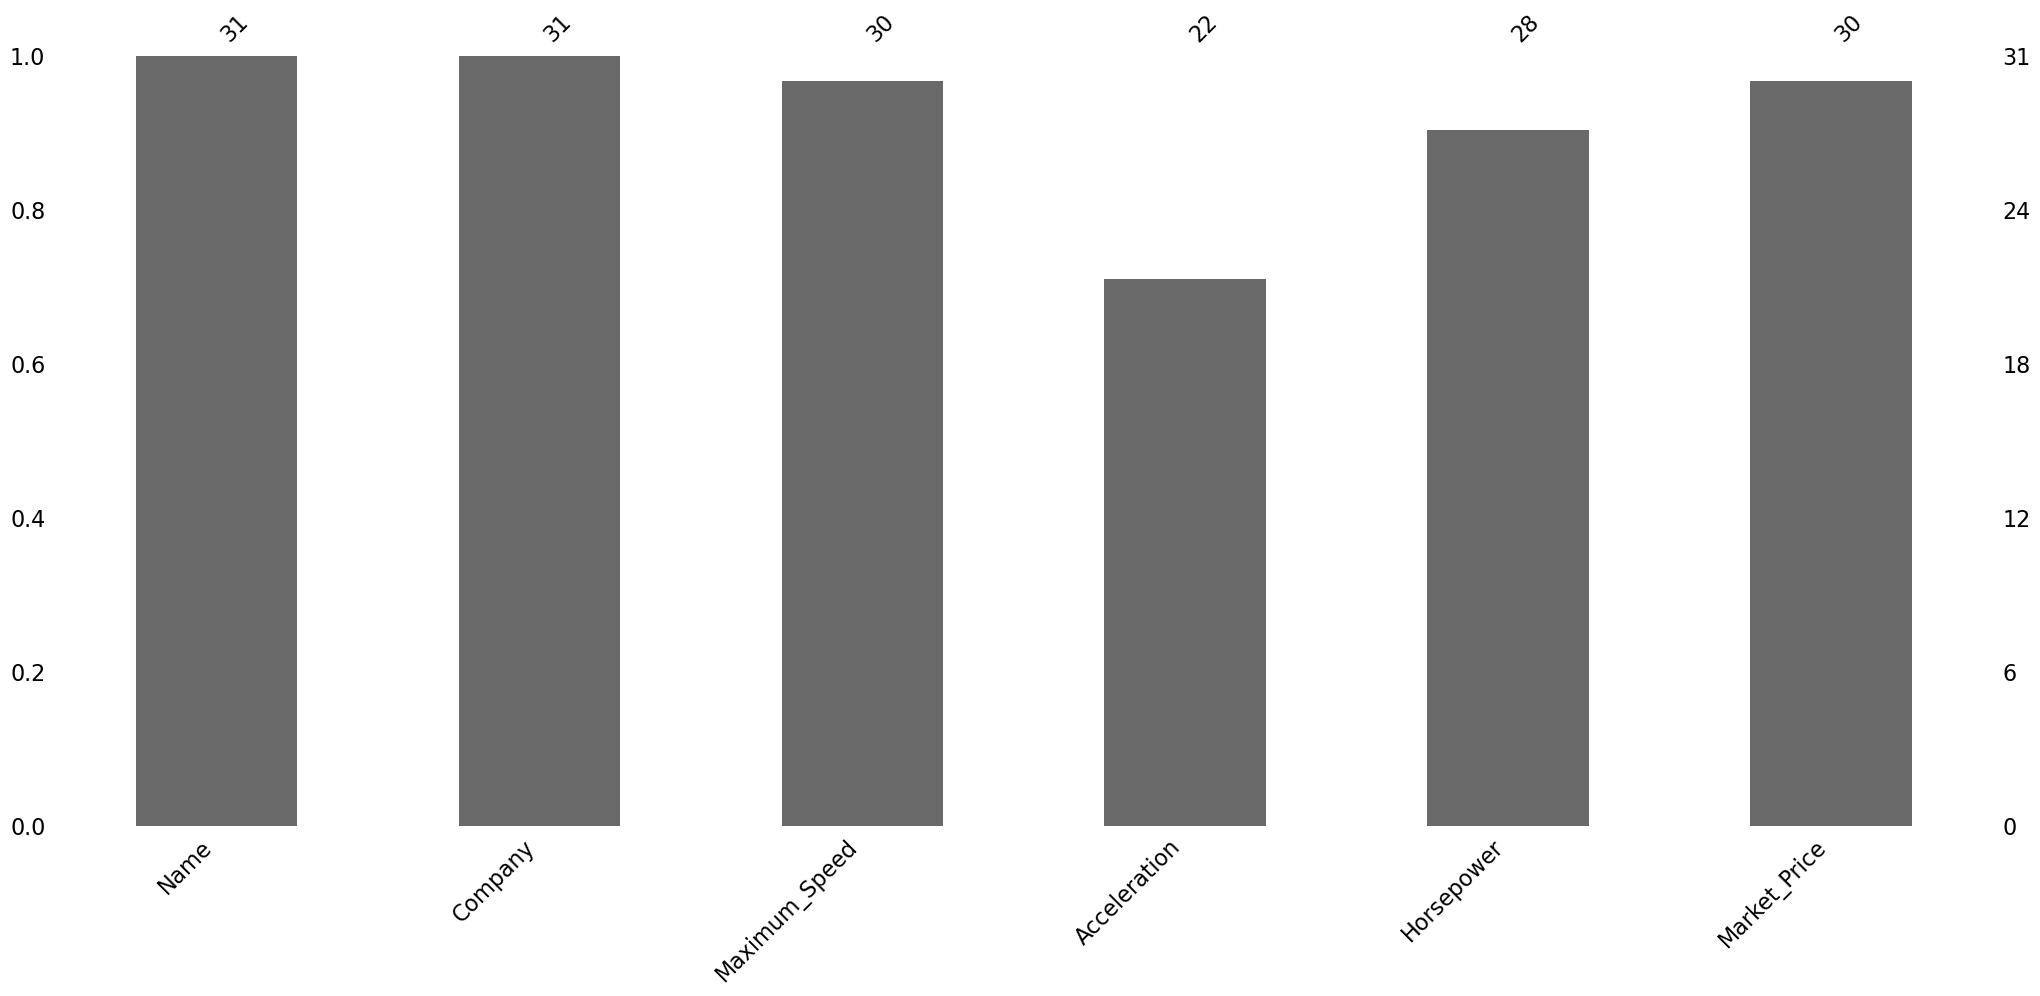

In [12]:
msno.bar(cars)
plt.show()

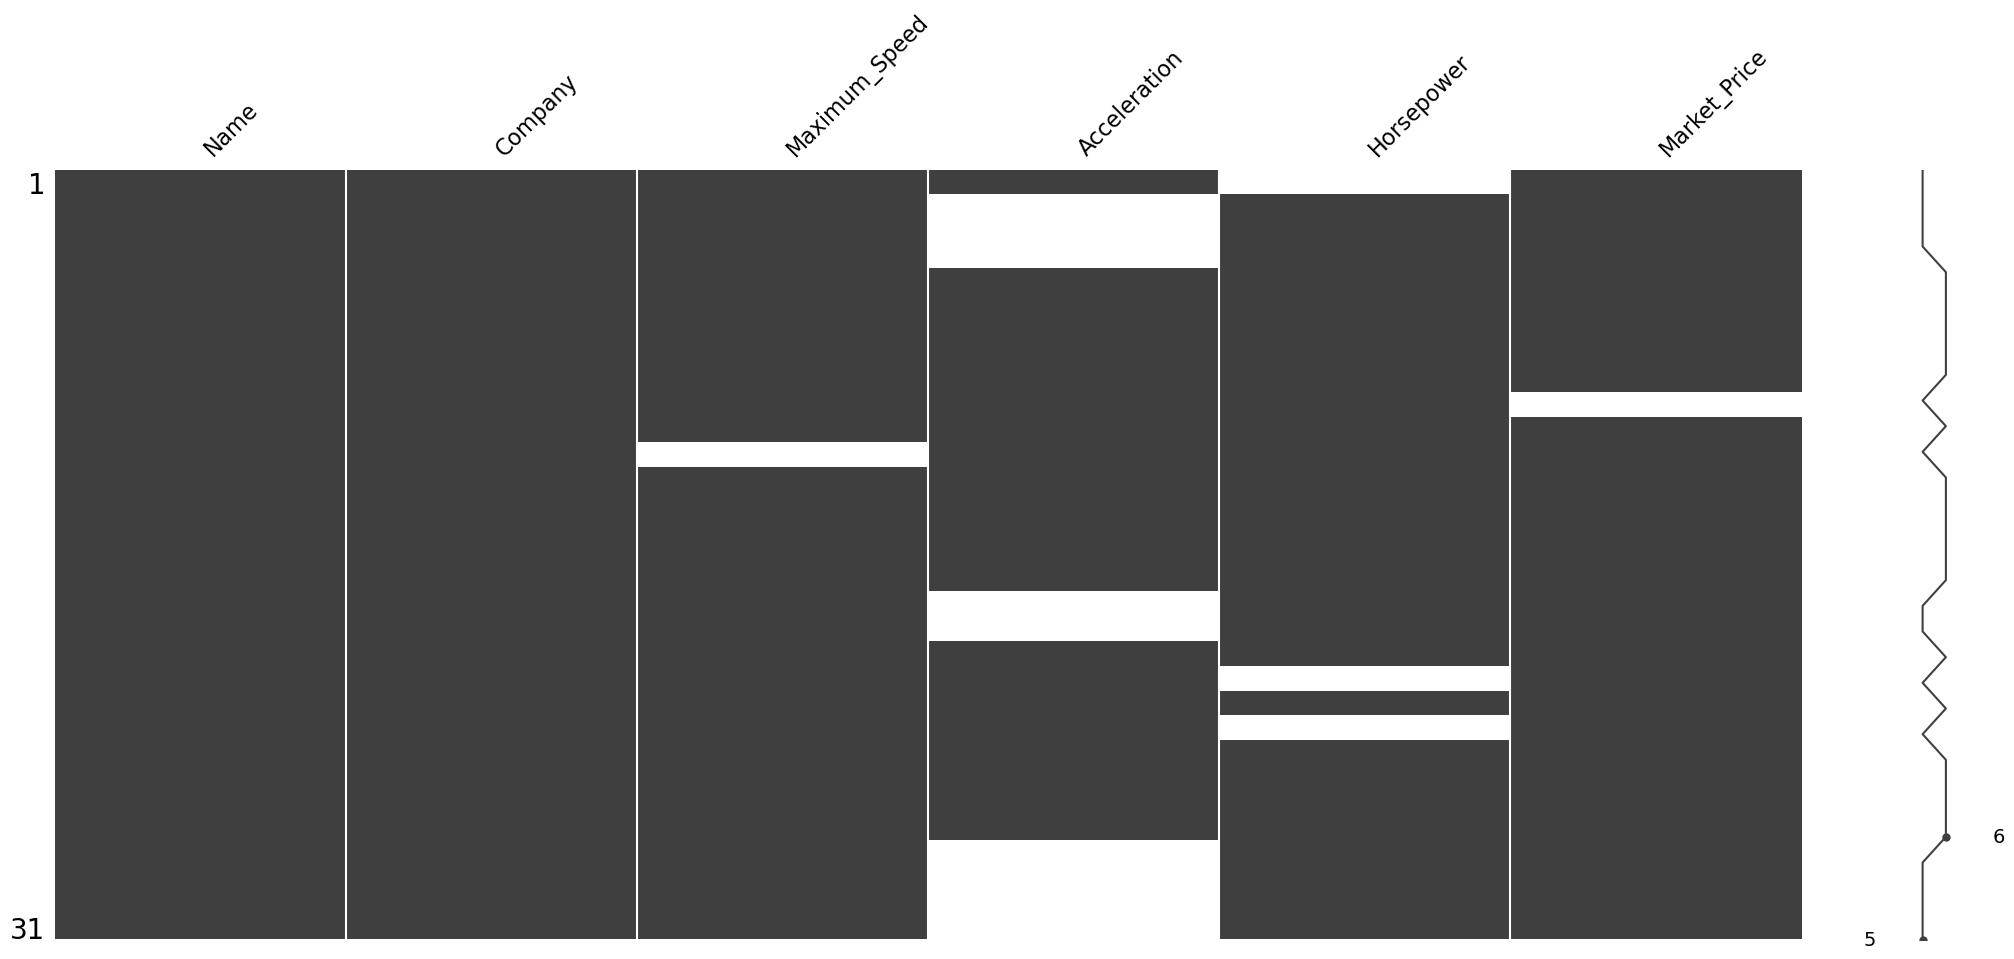

In [13]:
msno.matrix(cars)
plt.show()

Acceleration data is the most incomplete.

And by car company?

In [14]:
cars.groupby("Company").apply(lambda x: x.isnull().any(axis=1).sum())

Company
Audi          4
BMW           0
Ferrari       1
Mercedes      1
Porsche       0
Skoda         2
Tesla         2
Toyota        0
Volkswagen    4
dtype: int64

Audi and Volkswagen have the most incomplete rows.

Next we'll look at the market prices of the models of the companies.

In [15]:
cars_market_price_not_null = cars[cars["Market_Price"].notnull()]

grouped_by_company = cars_market_price_not_null.groupby("Company")["Market_Price"].mean()
ordered_market_price = grouped_by_company.sort_values(ascending=False)

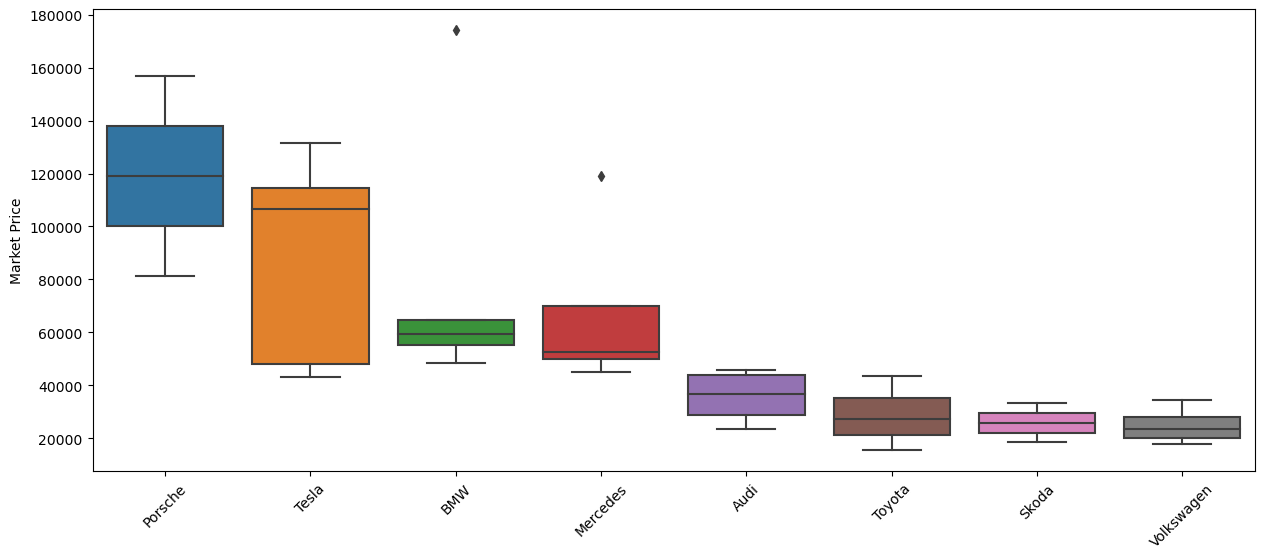

In [16]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_market_price_not_null, x = "Company", y = "Market_Price", order = ordered_market_price.index)
plt.xlabel("")
plt.ylabel("Market Price")
plt.xticks(rotation=45)
plt.show()

There seems to be two different classes: Audi, Toyota, Volkswagen and Skoda produce the cheap cars, the other companies do not. This will be checked out using a t-test. Because the variances are different, Welch's t-test is used.

In [17]:
cheap_cars_list = ["Audi", "Toyota", "Volkswagen", "Skoda"]
cheap_cars = cars_market_price_not_null.loc[cars_market_price_not_null["Company"].isin(cheap_cars_list), ["Company", "Market_Price"]]
expensive_cars = cars_market_price_not_null.loc[~cars_market_price_not_null["Company"].isin(cheap_cars_list), ["Company", "Market_Price"]]

t_statistic, p_value = stats.ttest_ind(cheap_cars.Market_Price, expensive_cars.Market_Price, equal_var=False)
print("Welch's t-statistic:", t_statistic)
print("p-value:", p_value)

Welch's t-statistic: -5.353683839072592
p-value: 4.049219379623464e-05


The average market price between these two groups is significant. This difference is visualized in the following plot.

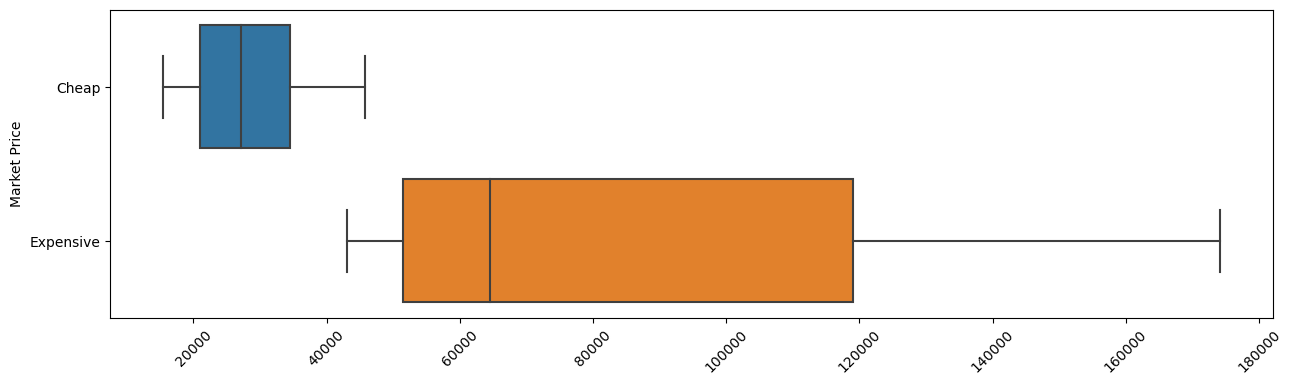

In [18]:
cheap_expensive = pd.DataFrame({"Type": ["Cheap"]*cheap_cars.shape[0] + ["Expensive"]*expensive_cars.shape[0],
                                "Market_Price": pd.concat([cheap_cars.Market_Price, expensive_cars.Market_Price])})

plt.figure(figsize=(15, 4))
sns.boxplot(data = cheap_expensive, y = "Type", x = "Market_Price", orient="h")
plt.xlabel("")
plt.ylabel("Market Price")
plt.xticks(rotation=45)
plt.show()

Next the maximum speed of the cars is investigated.

In [19]:
cars_max_speed_not_null = cars[cars["Maximum_Speed"].notnull()]

grouped_by_company = cars_max_speed_not_null.groupby("Company")["Maximum_Speed"].mean()
ordered_max_speed = grouped_by_company.sort_values(ascending=False)

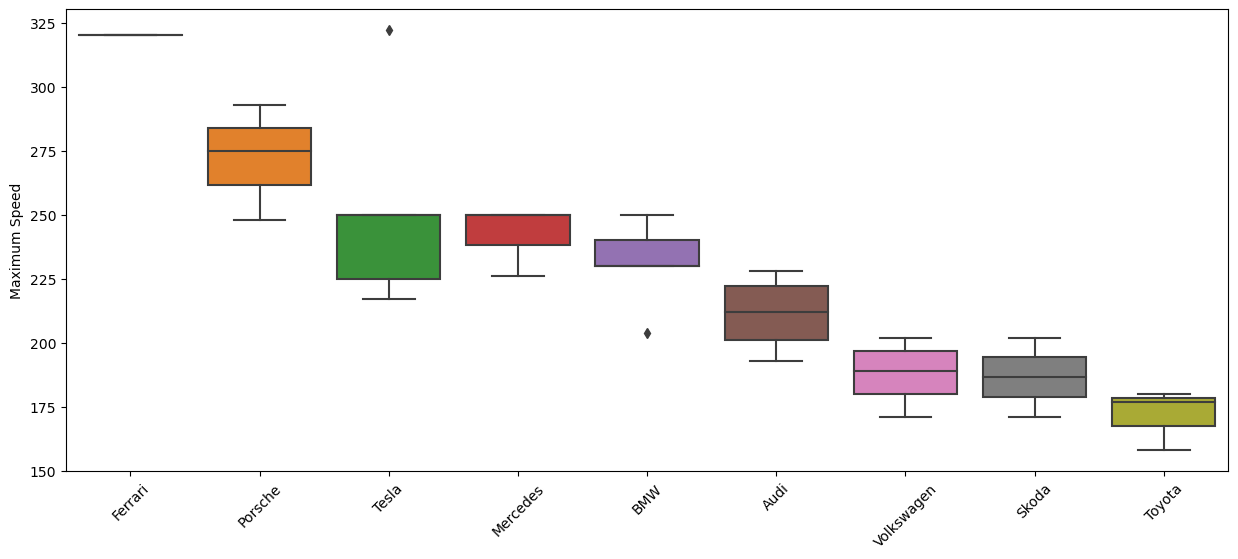

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_max_speed_not_null, x = "Company", y = "Maximum_Speed", order = ordered_max_speed.index)
plt.xlabel("")
plt.ylabel("Maximum Speed")
plt.xticks(rotation=45)
plt.show()

Finally we look at the acceleration.

In [21]:
cars_acceleration_not_null = cars[cars["Acceleration"].notnull()]

grouped_by_company = cars_acceleration_not_null.groupby("Company")["Acceleration"].mean()
ordered_acceleration = grouped_by_company.sort_values(ascending=True)

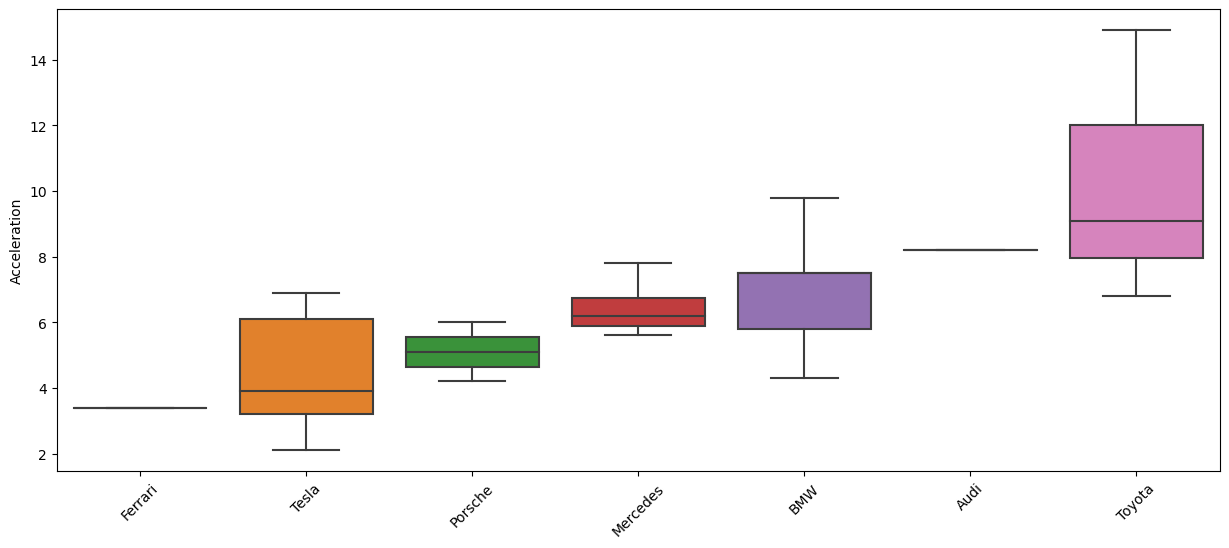

In [22]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_acceleration_not_null, x = "Company", y = "Acceleration", order = ordered_acceleration.index)
plt.xlabel("")
plt.ylabel("Acceleration")
plt.xticks(rotation=45)
plt.show()

Next up is horsepower.

In [23]:
cars_horsepower_not_null = cars[cars["Horsepower"].notnull()]

grouped_by_company = cars_horsepower_not_null.groupby("Company")["Horsepower"].mean()
ordered_horsepower = grouped_by_company.sort_values(ascending=False)

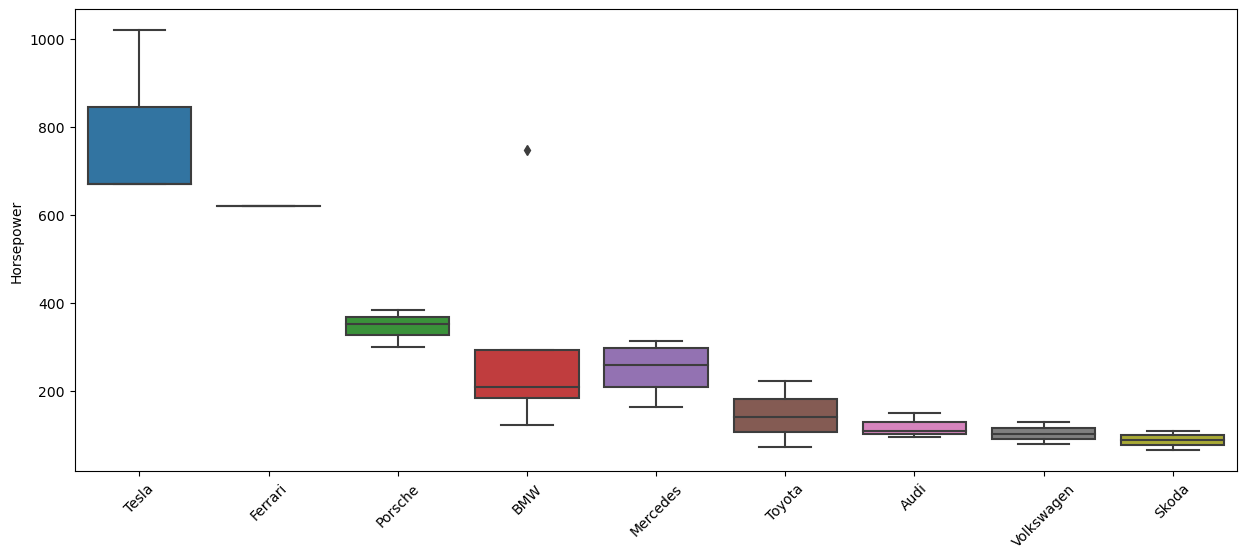

In [24]:
plt.figure(figsize=(15, 6))
sns.boxplot(data = cars_horsepower_not_null, x = "Company", y = "Horsepower", order = ordered_horsepower.index)
plt.xlabel("")
plt.ylabel("Horsepower")
plt.xticks(rotation=45)
plt.show()

Tesla, Ferrari and an outlier of BMW have by far the highest horsepower.

What is the relationship between maximum speed and market price? There is a positive relationship, as the correlation coefficient is 0.79.

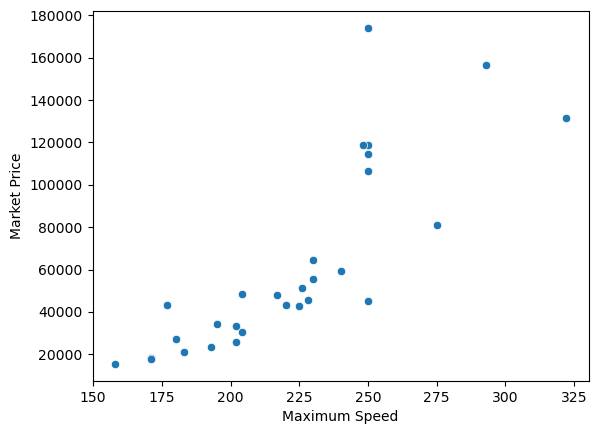

In [25]:
sns.scatterplot(data = cars, x = "Maximum_Speed", y = "Market_Price")
plt.xlabel("Maximum Speed")
plt.ylabel("Market Price")
plt.show()

In [26]:
correlation = cars.Maximum_Speed.corr(cars.Market_Price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: 0.81


In [27]:
from scipy.stats import pearsonr
df = cars[["Maximum_Speed", "Market_Price"]].dropna()
pearsonr(df.Maximum_Speed, df.Market_Price)

PearsonRResult(statistic=0.8148944215421757, pvalue=7.387563307904875e-08)

What is the relationship between acceleration and market price? There is a negative relationship, as the correlation coefficient is 0.68.

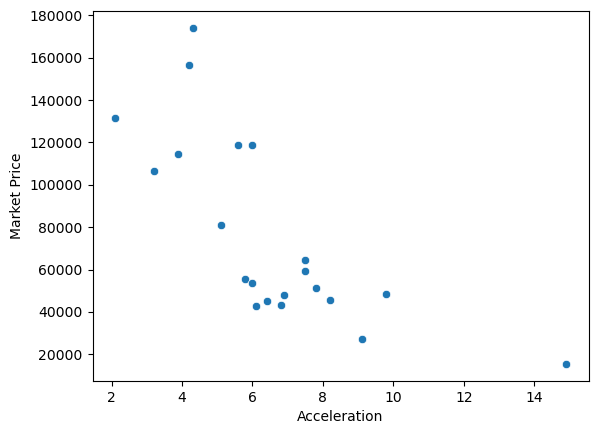

In [29]:
sns.scatterplot(data = cars, x = "Acceleration", y = "Market_Price")
plt.xlabel("Acceleration")
plt.ylabel("Market Price")
plt.show()

In [ ]:
correlation = cars.acceleration.corr(cars.market_price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: -0.71


What is the relationship between horsepower and market price? There is a positive relationship, as the correlation coefficient is 0.83.

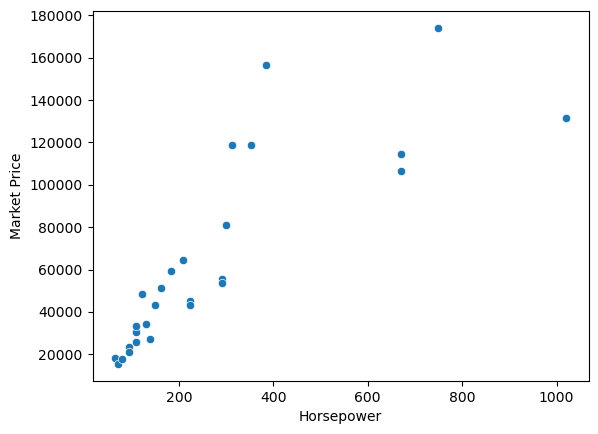

In [30]:
sns.scatterplot(data = cars, x = "Horsepower", y = "Market_Price")
plt.xlabel("Horsepower")
plt.ylabel("Market Price")
plt.show()

In [31]:
correlation = cars.Horsepower.corr(cars.Market_Price)
print("Correlation Coefficient:", round(correlation, 2))

Correlation Coefficient: 0.83


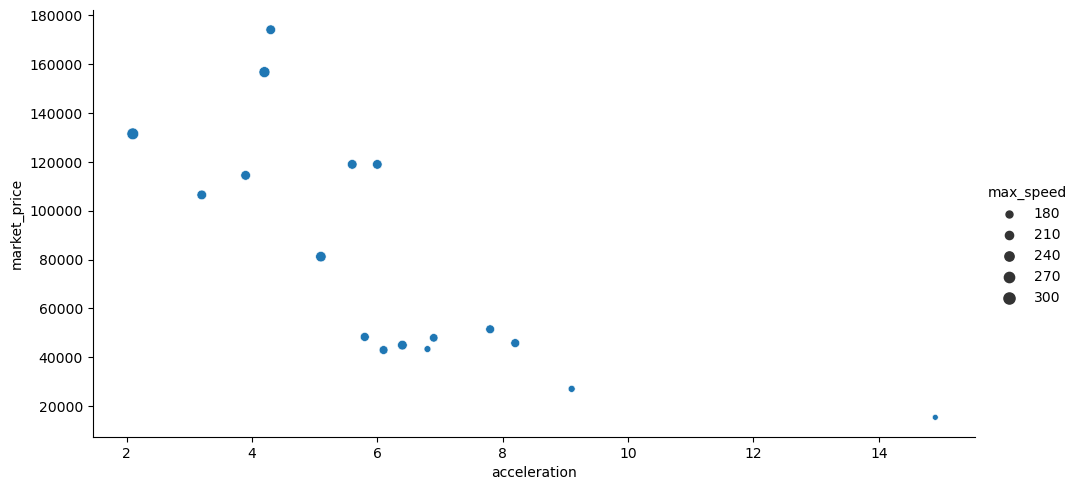

In [ ]:
sns.relplot(data = cars, x = "acceleration", y = "market_price", size = "max_speed", height=5, aspect=2)
plt.show()